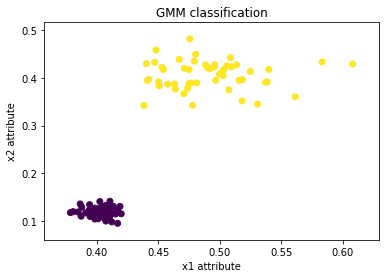

In [31]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs  

#生成的簇，和对应的分类
#这是sklearn的聚类结果
#下面自己编码GMM实现聚类，看看与sklearn的结果是够一致
x,label = make_blobs(n_samples=100,n_features=2, centers=2,
                     cluster_std=[0.01, 0.03],
                     center_box=(0.1, 0.8),
                     random_state=2)  
plt.scatter(x[:, 0],x[:, 1], marker='o', c=label) 
plt.title('GMM classification')
plt.xlabel('x1 attribute')
plt.ylabel('x2 attribute')
plt.show()

In [32]:
# K: 簇的个数
# D: 数据的维数（特征数或属性数）
# N：样本点个数
K = 2
D = 2
N = 100


#初始化参数
def initParams(K,D):
    #每个簇的中心值：K by D
    aves = np.random.rand(K,D)
    #每个簇的偏差 D by D by K
    sigmas = np.zeros((D,D,K))
    ###D by D 必须是对称矩阵
    sig = np.eye(D)
    for k in np.arange(0,K):
        sigmas[:,:,k] = sig
    #每个簇的影响系数：1 by K
    pPis = np.random.rand(1,K)
    return aves,sigmas,pPis
 
 #样本点对簇的贡献系数
    #pPi : 1 by K
    #px: N by K
    # return value: N by K
def fgamma(px,pPi):
    #gamma公式的分子部分
    #fenzi: N by K
    fenzi = pPi * px 
    #gamma公式的分母部分
    #fenmu: N by 1
    fenmu = np.sum(fenzi,axis=1).reshape(N,1)
    return fenzi/fenmu

# 每个簇中的样本点的贡献系数之和
    # gam: N by K
    # return value: 1 by K

def fNk(gam):
    nk = np.sum(gam,axis=0)
    # 1-d to 2-d
    return nk.reshape(1,K)

#每个簇的均值
    # Nk: 1 by K
    # gam: N by K
    # x : N by D
    #return value: K by D
def faverage(aves,Nk,gam,x):
    #print(np.shape(Nk))
    for k in np.arange(0,K):
        # sum : D
        sumn = np.sum((gam[:,k].reshape(N,1)) * x,axis=0)
        aves[k,:] = sumn.reshape(1,D)/Nk[:,k]

#每个簇的方差
    # Nk: 1 by K
    # gam: N by K
    # x : N by D
    # aves: K by D
    #return value: D by D by K

def fsigma(sigmas,Nk,gam,x,aves):
    for k in np.arange(0,K):
        #shift: N by D
        shift = x - aves[k,:]
        #shift_gam: N by D        
        shift_gam = gam[:,k].reshape(N,1)*shift
        #shift2 : D by D
        shift2 = shift_gam.T.dot(shift)
        sigmas[:,:,k] = shift2/Nk[:,k]
        #print(sigmas[:,:,k])
    return sigmas

# D-dimension prob density
# x ： N by D
# aves : K by D
# sigmas: D by D by K
    # return value: N by K
def fpx(x,aves,sigmas):
    Px = np.zeros((N,K))
    # coef1 : 1 by 1
    coef1 = np.power((2*np.pi),(D/2.0))
    for k in np.arange(0,K):
        # coef2 : 1 by 1
        coef2 = np.power((la.det(sigmas[:,:,k])),0.5)
        coef3 = 1/(coef1 * coef2)
        # shift: N by D
        shift = x - aves[k,:]
        # sigmaInv: D by D
        #print(sigmas[:,:,k])
        sigmaInv = la.inv(sigmas[:,:,k])
        epow = -0.5*(shift.dot(sigmaInv)*shift)
        # epowsum : N
        epowsum = np.sum(epow,axis=1)        
        Px[:,k] = coef3 * np.exp(epowsum)

    return Px

#迭代求解的停止策略
    #px: N by K
    #pPi: 1 by K
    
#Loss function  1 by 1  
def fL(px, pPi):
    # sub: N by 1
    sub = np.sum(pPi*px,axis=1)
    logsub = np.log(sub)
    curL = np.sum(logsub)
    #print(curL)
    # curL: 1 by 1
    return curL
    
# stop iterator strategy
def stop_iter(threshold,preL,curL):
    return np.abs(curL-preL) < threshold

# GMM 
# return value: N by K
def GMM(x,K):
    #loss value initilize
    preL = -np.inf;
    # aves 每个簇的中心值：K by D
    # sigmas 每个簇的偏差 D by D by K
    # pPi 每个簇的影响系数：1 by K
    aves,sigmas,pPi = initParams(K,D)
    while True:
        # px: 每个数据所属簇的概率 N by K
        #print(aves)
        #print(sigmas)
        px = fpx(x,aves,sigmas)
        #print(px)
        # 贡献系数 N by K
        gam = fgamma(px,pPi)
        #每个簇中的样本点的贡献系数之和 1 by K
        Nk = fNk(gam)
        pPi = Nk/N
        #print(pPi)
        # 每个簇的均值 K by D
        faverage(aves,Nk,gam,x)
        #每个簇的方差 D by D by K
        fsigma(sigmas,Nk,gam,x,aves)
        # loss function
        #print(px)
        #print(pPi)
        curL = fL(px, pPi)
        #迭代求解的停止策略
        if stop_iter(1e-15,preL, curL):
            break
        #print(sigmas[:,:,0])
        #print(px)
        preL = curL
        #print(curL)
    return px,aves,sigmas

#返回聚类的结果：N 
def classifior(px):
    rslt = []
    for row in px:
        rslt.append(np.where(row==np.max(row)))
    return np.array(rslt).reshape(-1)

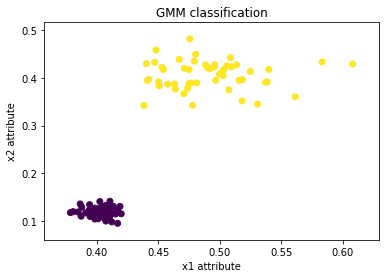

In [33]:
#一维特征的GMM聚类模拟
px,aves,sigmas =GMM(x,2)
mylabel = classifior(px)
#可以看到与sklearn的模拟结果是一致的
plt.scatter(x[:, 0],x[:, 1], marker='o', c=mylabel) 
plt.title('GMM classification')
plt.xlabel('x1 attribute')
plt.ylabel('x2 attribute')
plt.show()

In [34]:
px

array([[  3.10126812e+002,   5.16194629e-020],
       [  6.20089342e+001,   7.03528509e-021],
       [  1.02888688e+002,   1.12971403e-016],
       [  8.58372494e-155,   9.07370504e+001],
       [  6.28123785e-212,   1.21772328e+002],
       [  5.69619792e+002,   6.03878122e-018],
       [  5.69932241e+002,   1.47373184e-021],
       [  3.31317013e-197,   4.00904847e+001],
       [  1.13708791e+003,   6.27980772e-019],
       [  1.80718617e+002,   6.85616069e-018],
       [  7.50879900e-209,   1.28023691e+002],
       [  3.12583070e-218,   9.13058080e+001],
       [  1.27577784e+003,   6.29536002e-019],
       [  1.69652682e-206,   1.27589458e+002],
       [  4.17255319e+002,   4.56976159e-018],
       [  1.36091077e-155,   5.42428990e+001],
       [  1.11853312e+003,   5.10877997e-019],
       [  9.12040082e-192,   7.28773091e+001],
       [  3.43034591e+002,   5.33882267e-019],
       [  9.02697586e+002,   9.48331549e-019],
       [  6.02762174e+002,   6.30617379e-018],
       [  1.1

In [35]:
aves

array([[ 0.4027345 ,  0.11889877],
       [ 0.49076433,  0.40577647]])

In [40]:
sigmas[:,:,0]

array([[  9.15986680e-05,  -8.01442383e-06],
       [ -8.01442383e-06,   1.10096387e-04]])

In [41]:
sigmas[:,:,1]

array([[  1.33265922e-03,   4.65569067e-06],
       [  4.65569067e-06,   8.89605528e-04]])

In [8]:
a = np.array([[1],[2],[3]])
square = np.zeros((3,3))
for i in np.arange(0,3):
    square[i,i]=a[i]
square

array([[ 1.,  0.,  0.],
       [ 0.,  2.,  0.],
       [ 0.,  0.,  3.]])

In [12]:
a

array([[1],
       [2],
       [3]])

In [13]:
b = np.array([[1,2],[3,4],[5,6]])

In [14]:
b

array([[1, 2],
       [3, 4],
       [5, 6]])

In [15]:
a*b

array([[ 1,  2],
       [ 6,  8],
       [15, 18]])

In [16]:
square.dot(b)

array([[  1.,   2.],
       [  6.,   8.],
       [ 15.,  18.]])